In [201]:
import boto3
import sagemaker
import numpy as np
import pandas as pd
from sagemaker import TrainingInput, get_execution_role
from sagemaker.xgboost import XGBoost, XGBoostModel

In [202]:
bucket='MY-BUCKET-NAME'
abalone_df = pd.read_csv(f"./abalone-dataset.csv")
abalone_df["Sex"] = abalone_df["Sex"].astype("category")

abalone_df["Sex"] = abalone_df["Sex"].map(lambda x: 0 if x == "F" else (1 if x == "M" else -1))

train, validate, test = np.split(abalone_df.sample(frac=1), [int(.6*len(abalone_df)), int(.8*len(abalone_df))])
train.to_csv(f"s3://{bucket}/abalone/train.csv")
validate.to_csv(f"s3://{bucket}/abalone/validate.csv")
test.to_csv(f"s3://{bucket}/abalone/test.csv")

In [237]:
hyperparameters = {
        "max_depth": "6",
        "eta": "0.002722527908770324",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.7",
        "objective": "reg:linear",
        "num_round": "500",
        "verbosity": "2",
        "eval_metric": "accuracy",
        "early_stopping_rounds": "10",
    }

In [238]:
output_path = 's3://{}/{}/{}/output'.format(bucket, "abalone", 'abalone-xgb-built-in-algo')
xgboost_container = sagemaker.image_uris.retrieve("xgboost", "us-east-1", "1.2-2")
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)


In [239]:
train_input = TrainingInput(f"s3://{bucket}/abalone/train.csv", content_type="text/csv")
validate_input = TrainingInput(f"s3://{bucket}/abalone/validate.csv", content_type="text/csv")
test_input = TrainingInput(f"s3://{bucket}/abalone/test.csv", content_type="text/csv")

In [241]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------!

In [242]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])
    
    return np.fromstring(predictions[1:], sep=',')

In [243]:
test_data = pd.read_csv(f"s3://{bucket}/abalone/test.csv")

In [244]:
predictor.serializer = sagemaker.serializers.CSVSerializer()
predictions = predict(test_data.drop(["Rings"], axis=1).to_numpy())

In [245]:
from sklearn.metrics import mean_squared_error
print("Mean Squared Error ==> " + str(np.sqrt(mean_squared_error(test_data["Rings"], predictions))))

Mean Squared Error ==> 5.576827549305876


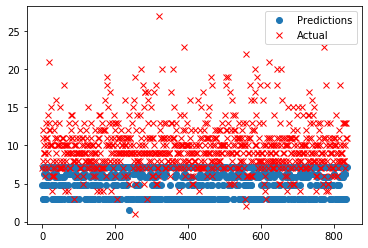

In [248]:
d = {'Predictions' : predictions,
     'Actual' : test_data["Rings"]}

df = pd.DataFrame(d)
df.plot(style=['o','rx'])